In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
#from lavis.models import load_model_and_preprocess
#import cuda

In [2]:
with torch.cuda.device(torch.device('cuda:4')): 
    info = torch.cuda.mem_get_info()
print(info[0] / info[1])
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device, device2)


0.9926922699652554
cuda:4 cuda:4


In [3]:
import modules

In [14]:
blip = modules.BLIPModel(gpu_number=3)

2023-12-23 12:46:42.275785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 12:46:42.275827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 12:46:42.277025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 12:46:43.496680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
blip.caption()

In [4]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [5]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [6]:
siglip = modules.SiglipModel(gpu_number=3)

In [7]:
transform = T.ToPILImage()
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]

In [9]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
#from lavis.models import load_model_and_preprocess
#import cuda
import modules
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape
siglip = modules.SiglipModel(gpu_number=3)
transform = T.ToPILImage()
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
siglip.forward(images, query="Woman in blue with headphones")

KeyboardInterrupt: 

In [ ]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


133/167


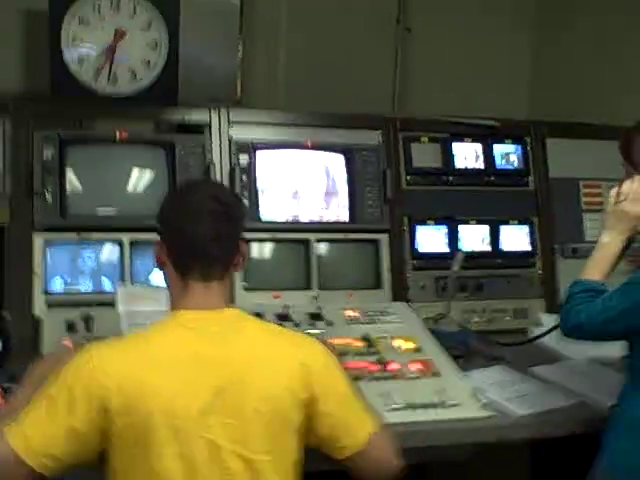

In [24]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [46]:
blip.qa(raw_image, "ok")

['in the studio']

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

In [ ]:
import openai

with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message


In [ ]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    with open('./prompts/base_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def final_select(question, choices, info):
    with open('./prompts/final_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(choices))
    prompt = prompt.replace('insert_info', str(info))
    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [ ]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    return caption

In [ ]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    final_output = final_select(question, answer_choices, info)
    return final_output

In [ ]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [ ]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# Q1

In [ ]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{images.shape[0]}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
caption = model.generate({"image": image})
print(caption)
raw_image

In [ ]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

# Q2

In [ ]:
video_id = 4010069381
question = "why does the lady walks away after the conversation with man is over?"
options = ['pick up phone', 'enjoying stroll', 'giving her space to perform', 'help man do something else', 'performance ended']

images, caption = answer_question_half(video_id, question, options, "lady walking away")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q3

In [ ]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3489439407
question = "what are the two men doing as the lady in blue stands and listen via her headphone?"
options = ['turns around', 'working on the radio', 'moving the papers', 'walk forward', 'choosing a flower']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "lady in blue standing listening to her headphones")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3814690167
question = "why did the man in glasses bounce up and down at the start of the video?"
options = ['warm up', 'supportive audience', 'clap to the beats', 'to show his passion for dancing', 'begin to sing']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "man in glasses bouncing up and down")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q5

In [ ]:
video_id = 11566980553
question = "how does the woman respond after the boy gives her the present?"
options = ['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman recieving present from boy")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

In [ ]:
final_select(question, options, {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii'], "What is the woman's reaction to the boy's present?": ['happy'], "What is the woman's reaction to the boy's gift?": ['happy'], 'What is the woman doing in the video?': ['eating'], 'What are the kids doing on top of the couch?': ['playing'], 'What is happening in the video?': ['playing wii']}, 'Frame 150': {'caption': ['a young boy sitting on the floor reading a book']}, 'Frame 30': {'caption': ['a couple of kids sitting on top of a couch']}, 'Frame 133': {'caption': ['a young boy sitting on the floor holding a wii remote']}})

In [ ]:
"['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']",,how does the woman respond after the boy gives her the present?,1,11566980553.mp4

- Image level allows you to go back and forth in time, can't do in video-models
    - Binary search aspect -> start in middle -> move forward if not
    - Exponential or recursive
- Image level leveraging for video -> algorithm efficiency analysis
- Show that it works for multiple datasets
- List of different datasets other than NextQA

In [ ]:
import dataset

In [ ]:
dataset.get_data("queries_2k.csv")